In [1]:
from sklearn.datasets import load_iris
import numpy as np
import math
from tqdm import tqdm
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

Creo el modelo inicial.

In [2]:
model = LogisticRegression(C=0.5,random_state=0)

Realizo la lectura de archivos.

In [3]:
iden = pd.read_csv('train_identity.csv')

In [4]:
trans = pd.read_csv('train_transaction.csv')

Mergeo los dos dataframes cargados anteriormente.

In [5]:
joined = trans.merge(iden,how='left')

Libero espacio en la RAM de los dos DF iniciales que no utilizare más.

In [6]:
del iden

In [7]:
del trans

Busco el valor para realizar el split del train y del validation, quedandome con el 80% del df para el train y con el 20% restante para el validation.

In [8]:
limite = np.percentile(joined['TransactionDT'], 80)

Filtro en el df para generar el train y el validation, y sus labels.

*Validation*

In [9]:
filtro1 = joined['TransactionDT'] > limite

In [10]:
validation = joined[filtro1]

In [11]:
label2=validation['isFraud']

In [12]:
del(validation['isFraud'])

*Train*

In [13]:
filtro2 = joined['TransactionDT']<= limite

In [14]:
train = joined[filtro2]

In [15]:
label = train[['isFraud']]

In [16]:
del(train['isFraud'])

Elimino los IDs unicos por consigna.

In [17]:
del(train['TransactionID'])

Libero espacion en la RAM, eliminando un df que ya no utilizare.

In [18]:
del joined

Creo el diccionario donde almacenare los encodings de cada feature.

In [19]:
dict_one_hot = {}

In [20]:
le = {}

Creo las funciones que utilizare a continuacion para realizar los encodings

In [21]:
def one_hot_encode(df, columna, dict_one_hot):
    if columna not in dict_one_hot:
        dict_one_hot[columna] = OneHotEncoder(handle_unknown='ignore')
        dict_one_hot[columna].fit_transform(df[[columna]].astype(str)).astype(int)
    col_encoded = (dict_one_hot[columna].transform(df[[columna]].astype(str)).astype(int))
    col_encoded = pd.DataFrame(col_encoded.todense()).add_prefix(columna + '_').fillna(0)
    del(df[columna])
    df_nuevo = pd.concat([df.reset_index(drop=True), col_encoded], axis=1)
    return df_nuevo

In [22]:
def ordinal_enc(df,le):
    for column in df.columns:
        if df[column].dtypes==object:
            le[column] = OrdinalEncoder(handle_unknown='ignore')
            df[column] = le[column].fit_transform(df[column].astype(str).values.reshape(-1, 1))
    df.fillna(-1,inplace=True)
    return(df)

## TRAIN

Realizo los encodings.

In [23]:
train = one_hot_encode(train,'id_34',dict_one_hot)

In [24]:
train = one_hot_encode(train,'id_35',dict_one_hot)

In [25]:
train = one_hot_encode(train,'id_38',dict_one_hot)

In [26]:
train = one_hot_encode(train,'ProductCD',dict_one_hot)

In [27]:
train = one_hot_encode(train,'card4',dict_one_hot)

In [28]:
train = one_hot_encode(train,'P_emaildomain',dict_one_hot)

In [29]:
train = ordinal_enc(train,le)

Entreno el modelo.

In [30]:
model.fit(train, label)

LogisticRegression(C=0.5, random_state=0)

### VALIDATION

Elimino los IDs unicos por consigna.

In [31]:
del(validation['TransactionID'])

Realizo los encodings.

In [32]:
validation = one_hot_encode(validation,'id_34',dict_one_hot)

In [33]:
validation = one_hot_encode(validation,'id_35',dict_one_hot)

In [34]:
validation = one_hot_encode(validation,'id_38',dict_one_hot)

In [35]:
validation = one_hot_encode(validation,'ProductCD',dict_one_hot)

In [36]:
validation = one_hot_encode(validation,'card4',dict_one_hot)

In [37]:
validation = one_hot_encode(validation,'P_emaildomain',dict_one_hot)

In [38]:
validation = ordinal_enc(validation,le)

Muestro el classification_report

In [39]:
print(classification_report(label2, model.predict(validation)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114044
           1       0.00      0.00      0.00      4064

    accuracy                           0.96    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.96      0.95    118108



Se calcula el roc auc con el modelo manual.

In [40]:
roc_auc_score(label2, model.predict_proba(validation)[:,1])

0.6911885003046206

### TEST

Realizo la lectura de archivos.

In [41]:
idenTest = pd.read_csv('test_identity.csv')

In [42]:
transTest = pd.read_csv('test_transaction.csv')

Verifico los nombres de los features, dado que en un primer momento me ha lanzado un error.

In [43]:
idenTest.columns

Index(['TransactionID', 'id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06',
       'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14',
       'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22',
       'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30',
       'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

Genero una funcion para renombrar los features ids dado que son distintos a los del train y el validation.

In [44]:
def renombrar(df):
    for columna in df.columns:
        if columna.startswith('id'):
            ss = columna.split('-')
            df.rename(columns={columna:ss[0]+'_'+ss[1]},inplace=True)
    return (df)
        

In [45]:
idenTest = renombrar(idenTest)

In [46]:
idenTest.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

Realizo el merge de los dos df.

In [47]:
test = transTest.merge(idenTest,how='left')

Me guardo el TransactionID dado que lo necesatare luego para generar el csv para la competencia.

In [48]:
ids = test[['TransactionID']]

In [49]:
del(test['TransactionID'])

Realizo los encodings.

In [50]:
test = one_hot_encode(test,'id_34',dict_one_hot)

In [51]:
test = one_hot_encode(test,'id_35',dict_one_hot)

In [52]:
test = one_hot_encode(test,'id_38',dict_one_hot)

In [53]:
test = one_hot_encode(test,'ProductCD',dict_one_hot)

In [54]:
test = one_hot_encode(test,'P_emaildomain',dict_one_hot)

In [55]:
test = one_hot_encode(test,'card4',dict_one_hot)

In [56]:
test = ordinal_enc(test,le)

Realizo el predict_proba.

In [57]:
prediccionModel = model.predict_proba(test)[:,1]

## Hiperparametros
Utilice RandomizedSearch de *Sklearn* para buscar los hiperparametros que mejoraron mi aucroc.

In [62]:
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
logistic = LogisticRegression(tol=1e-2, max_iter=1000,
                              random_state=0)
distributions = dict(C=[0.1,0.2,0.12,0.5,0.67,0.8,1],
                     penalty=['l2','l1'], solver=['lbfgs', 'saga', 'liblinear', 'sag'])
clf = RandomizedSearchCV(logistic, distributions, scoring='roc_auc',n_jobs=1, verbose=100, cv=3,n_iter=4, random_state=0)
search = clf.fit(train, label)
search.best_params_
"""

"\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform\nlogistic = LogisticRegression(tol=1e-2, max_iter=1000,\n                              random_state=0)\ndistributions = dict(C=[0.1,0.2,0.12,0.5,0.67,0.8,1],\n                     penalty=['l2','l1'], solver=['lbfgs', 'saga', 'liblinear', 'sag'])\nclf = RandomizedSearchCV(logistic, distributions, scoring='roc_auc',n_jobs=1, verbose=100, cv=3,n_iter=4, random_state=0)\nsearch = clf.fit(train, label)\nsearch.best_params_\n"

In [59]:
"""
import pickle
with open('model_backup_punto_2', 'wb') as model_backup_file:
    pickle.dump(search, model_backup_file)
"""

In [63]:
import pickle
with open('model_backup_punto_2', 'rb') as file:
    search = pickle.load(file)

In [64]:
print('Los mejores parametros resultaron los siguientes: ', search.best_params_)

Los mejores parametros resultaron los siguientes:  {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.8}


### Validation
Calculo nuevamente el *roc auc* y muestro el cassification report.

In [65]:
print(classification_report(label2, search.predict(validation)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114044
           1       0.25      0.03      0.05      4064

    accuracy                           0.96    118108
   macro avg       0.61      0.51      0.52    118108
weighted avg       0.94      0.96      0.95    118108



In [66]:
roc_auc_score(label2, search.predict_proba(validation)[:,1])

0.7488077216260225

### Test
Calculo el *predict proba* para la competencia, dado que me da un mejor roc auc el modelo generado con la busqueda de hiperparametros.

In [67]:
test['isFraud'] = search.predict_proba(test)[:,1]

In [68]:
test = test[['isFraud']]

In [69]:
join = ids.join(test)

In [70]:
join

,TransactionID,isFraud
0,3663549,0.005091
1,3663550,0.007144
2,3663551,0.012478
3,3663552,0.010386
4,3663553,0.010180
...,...,...
506686,4170235,0.013807
506687,4170236,0.503490
506688,4170237,0.010601
506689,4170238,0.012133


In [71]:
join.to_csv("entregaKaggle_punto_2_regresion_log.csv", index = False)

https://www.kaggle.com/c/ieee-fraud-detection/submit

#### Score en la competencia
<img src = 'score-Kaggle-punto-2.png' alt = "title">

### Busco y grafico los features mas importantes.

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
fs = SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=5)

In [73]:
importance = search.best_estimator_.coef_[0]

In [74]:
from matplotlib import pyplot
import numpy as np

In [75]:
for i,v in enumerate(importance):
    print('Feature: %0d, score: %.5f' %(i,v))


Feature: 0, score: 0.00000
Feature: 1, score: 0.00005
Feature: 2, score: -0.00005
Feature: 3, score: -0.00074
Feature: 4, score: -0.00026
Feature: 5, score: -0.00050
Feature: 6, score: -0.00001
Feature: 7, score: -0.00096
Feature: 8, score: -0.00031
Feature: 9, score: 0.00001
Feature: 10, score: 0.00008
Feature: 11, score: -0.00007
Feature: 12, score: 0.00014
Feature: 13, score: 0.00021
Feature: 14, score: -0.00000
Feature: 15, score: 0.00005
Feature: 16, score: -0.00004
Feature: 17, score: 0.00001
Feature: 18, score: 0.00006
Feature: 19, score: 0.00010
Feature: 20, score: -0.00003
Feature: 21, score: 0.00007
Feature: 22, score: 0.00007
Feature: 23, score: 0.00010
Feature: 24, score: -0.00017
Feature: 25, score: -0.00003
Feature: 26, score: -0.00055
Feature: 27, score: -0.00059
Feature: 28, score: -0.00012
Feature: 29, score: -0.00043
Feature: 30, score: -0.00016
Feature: 31, score: 0.00002
Feature: 32, score: -0.00004
Feature: 33, score: -0.00022
Feature: 34, score: 0.00000
Feature: 3

In [76]:
prom = train.mean().values

In [77]:
imporEscalado = abs(importance/prom)

In [78]:
ordenada = np.argsort(imporEscalado)[::-1]

In [79]:
ordenada

array([212, 211,  52, 486, 123,  56, 210,  83,  81,  67, 318,  66,  80,
        98, 130,  55,  82,  51, 121, 122, 142, 476,  58, 414,  71,  65,
       109, 129,  64, 141, 107,  57,  97,  70, 128, 134, 464, 447, 120,
       113, 220, 322, 493, 278, 267, 143, 317, 316, 383, 106,  50, 497,
       406, 315, 307, 271, 255, 380, 279, 236, 219, 108, 268, 306, 133,
       499, 250, 467, 217, 503, 150, 281, 248, 469, 227, 465, 270, 324,
       382, 249, 277, 225, 295, 330, 282, 266, 386, 112, 320, 502, 101,
       239,  89,  38, 473, 308,  14, 426, 409, 260, 413, 321, 152, 228,
       216, 280,  94,  23, 292, 254, 381, 388, 474, 500, 455, 293, 100,
        32, 238, 393, 144,  88,  39, 291, 475,  93, 485, 495, 226, 256,
       235,  19, 237, 323, 118,  18, 387, 312,  92, 119, 139, 477, 259,
       140, 442, 294, 480,  87, 453, 483, 389,  78, 368, 384, 488, 460,
        79, 310, 487, 491, 151, 484, 262, 496,  13, 498, 431,  91, 345,
       437, 184, 146, 490,  33, 439, 364, 358,  21, 454, 350,  9

In [80]:
top_10 = imporEscalado[ordenada][:10]

In [81]:
top_10

array([8.56477199e-03, 2.65268198e-04, 1.93272457e-04, 1.79664502e-04,
       1.77774552e-04, 1.76305507e-04, 1.66980085e-04, 1.04225774e-04,
       1.01044192e-04, 9.96859717e-05])

In [82]:
cols =  train.columns[ordenada[:10]]

In [83]:
cols

Index(['V163', 'V162', 'V3', 'P_emaildomain_39', 'V74', 'V7', 'V161', 'V34',
       'V32', 'V18'],
      dtype='object')

In [84]:
import seaborn as sns

In [85]:
df = pd.DataFrame({'features':cols,'values': top_10}) 

Text(0.5, 0, 'Features')

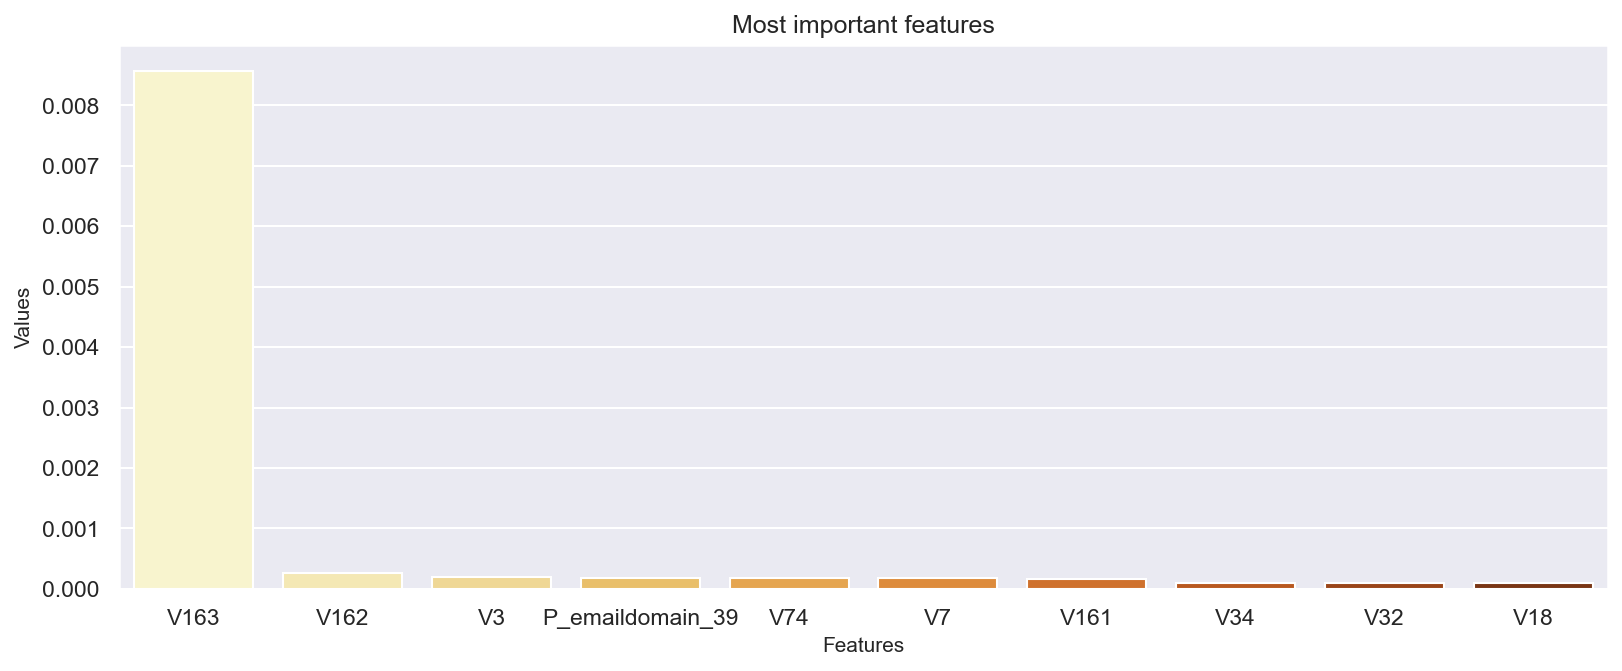

In [89]:
sns.set(rc={"figure.dpi":150})
sns.set(rc = {'figure.figsize':(12.8,4.8)})
ax = sns.barplot(x="features", y="values", data=df, palette ="YlOrBr")
ax.set_title('Most important features',size =12)
ax.set_ylabel('Values', fontsize = 10)
ax.set_xlabel('Features', fontsize = 10)

### Respuestas

1● ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el
dataset para validar?)

2● Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)

3● ¿Qué features son los más importantes para predecir con el mejor modelo? Grafica

1●  El mejor Score de validacion obtenido es ***0.7488***, obtenido con el modelo Search, es decir, con los hiperparametros buscados con el RandomizedSearch de Sklearn.
El dataset para validar lo obtuve estableciendo una fecha limite, la cual fechas anteriores tome como el train, y fechas siguientes a este limite, lo tomo como validation. De esta forma, estaria validando con datos a futuro incierto, lo que le da mayor validez a mi modelo.

2● El score obtenido para la competencia fue 0.7822.
<img src = 'score-Kaggle-punto-2.png' alt = "title">

3● El plot se visualiza anteriormente, y los features mas importantes para predecir con el mejor modelo, resultaron: ['V163', 'V162', 'V3', 'P_emaildomain_39', 'V74', 'V7', 'V161', 'V34', 'V32', 'V18']